In [104]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.svm import SVC
import seaborn as sns

import warnings

from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, KFold, train_test_split 

import matplotlib.pyplot as plt
%matplotlib inline

In [55]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb

In [414]:
from scipy import stats

# Functions for Project

In [337]:
#Function to put the training and testing accuracy of each model in a list of models
def model_results_dataframe(model_list, model_names, features_train, target_train, features_test, target_test):
    #Place to start 
    result_list = []
    
    for i, model in enumerate(model_list):
        #Fit the model to the data and make predictions
        model.fit(features_train, target_train)
        training_preds = model.predict(features_train)
        testing_preds = model.predict(features_test)
        
        #Accuracy scores for each model
        train_accuracy = accuracy_score(target_train, training_preds)
        test_accuracy = accuracy_score(target_test, testing_preds)
        
        #Put them in results
        result_list.append([model_names[i],train_accuracy, test_accuracy])
    
    column_names = ['Model Name', 'Training Accuracy', 'Testing Accuracy']
    results_df = pd.DataFrame(result_list, columns=column_names)
    results_df = results_df.sort_values(by=['Testing Accuracy'], ascending=False)
    return results_df

In [281]:
#Plots a confusion matrix of a given model

def plot_confusion_matrix(y_test, model_test):
    cm = metrics.confusion_matrix(y_test, model_test)
    plt.figure(1)
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    classNames = ['Non-User','User']
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    plt.show()

In [367]:
# Shows confusion matrix and classification report for a model after it has been fitted
def results_summary(mymodel, X_train, y_train, X_test, y_test):
    mymodel.fit(X_train, y_train)
    model_preds = mymodel.predict(X_test)
    
    model_accuracy = metrics.accuracy_score(y_test, model_preds)
    
    print("\n\nAccuracy Score: {}".format(model_accuracy))
    print("\n\nConfusion Matrix:")
    plot_confusion_matrix(y_test, model_preds)
    print("\n\nClassification Report:")
    print(metrics.classification_report(y_test, model_preds))

In [374]:
# Shows roc_curve for a model after it has been fitted.
def roc_curves(unfitted_model, X_train, y_train, X_test, y_test):
    unfitted_model.fit(X_train, y_train)
    model_preds = unfitted_model.predict(X_test)
    fpr, tpr, thresholds = roc_curve(model_preds,y_test)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='green', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [409]:
#Visualizes feature importance on a horizontal bar chart for a given model
def feature_importance_visualization(model, X_train, y_train, mytitle):
    model.fit(X_train, y_train)
    
    feature_importances = pd.Series(model.feature_importances_, X_train.columns).sort_values(ascending=True)

    
    plt.figure(figsize=(6,6))

    feature_importances.plot.barh(width=0.5)
    
    

    plt.title(mytitle)
    plt.show()

In [413]:
# Cohen's d for effect size
def Cohen_d(group1, group2):

    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled variance
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d

In [464]:
def ttest_helper(nonuser_sample, user_sample):
    t_stat, p_val = stats.ttest_ind(nonuser_sample, user_sample, equal_var=False) #equal_var = False means welch's t
    
    effect_size_quantity = round(nonuser_sample.mean() - user_sample.mean(),2)
    effect_size_cohen = round(Cohen_d(nonuser_sample, user_sample),3)
      
    return p_val, effect_size_quantity, effect_size_cohen
    

In [480]:
def dist_visualization(samp1, samp2, lab1, lab2):
    plt.figure(figsize=(10,6))
    sns.distplot(samp1, label=lab1, color='green')
    sns.distplot(samp2, label=lab2, color='red')
    plt.axvline(samp1.mean(),0,1, color='green', label=lab1+" Mean", linestyle='--')
    plt.axvline(samp2.mean(),0,1, color='red', label=lab2+" Mean", linestyle='--')
    plt.title(lab1 + " vs. " + lab2)
    plt.legend()
    warnings.filterwarnings("ignore")
    plt.show()

# Loading the Data and Preprocessing

In [3]:
drug_data = pd.read_csv('drug_consumption_clean.csv')

In [4]:
drug_data.head()

,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,...,Ecstasy,Heroin,Ketamine,Legal_Highs,LSD,Methadone,Mushrooms,Nicotine,Semeron,VSA
0,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL2,CL0,CL0
1,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
2,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
3,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
4,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0


In [5]:
# Features have already been pre-engineered for analysis- here insert discussion of how they were engineered

In [6]:
# Checking for null rows or columns
drug_data.isna().sum()

Age             0
Gender          0
Education       0
Country         0
Ethnicity       0
Nscore          0
Escore          0
Oscore          0
Ascore          0
Cscore          0
Impulsive       0
SS              0
Alcohol         0
Amphetamines    0
Amyl_Nitrite    0
Benzos          0
Caffeine        0
Cannabis        0
Chocolate       0
Cocaine         0
Crack           0
Ecstasy         0
Heroin          0
Ketamine        0
Legal_Highs     0
LSD             0
Methadone       0
Mushrooms       0
Nicotine        0
Semeron         0
VSA             0
dtype: int64

## <font color='red'> Note on Preprocessing and Dimensionality Reduction

**Data Source**

This dataset was pulled from UCI's machine learning database, and related to a study on drug use performed using an online survey in 2016. These researchers already did a fair amount of cleaning and preprocessing, which is why the data appears so clean above. The links to the UCI page from which I pulled the database and the actual study report are below.

https://archive.ics.uci.edu/ml/datasets/Drug+consumption+%28quantified%29

https://arxiv.org/pdf/1506.06297.pdf


**Reducing dimensionality through input feature transformation**

As part of the initial dataset, all of the feature columns had either nominal or ordinal data. For example, country had the names of the country and age had the actual ages. Given the number of different levels within each personality score and demographic level, using this data in its raw format would lead to a 250 dimensional space. Trying to fit a model in a 250 dimensional space would result in massively overfitting most of our models. 

As such, the original team that performed the study decided to transform all ordinal and nominal features into continuous variables for modelling purposes. Ordinal features (the personality scores) were transformed using polychoric correlation. The technique of polychoric correlation is based on the assumption that values of ordinal features result from the discretization of continuous random values with fixed thresholds

Nominal features (demographic info like country, education, etc.) was transofrmed using nonlinear Categorical PCA (CatPCA). 

For more details about the process of applying these transformations, please refer to the study pdf linked above, pages 12-13.

# <font color='green'> Classification Levels

For the purposes of this project, I will test two different classification levels. Below I create two different data frame and do some feature engineering within each of them to get them ready for modeling: 

1. Binary(user or non-user) - A User is someone who has used the drug in the past decade
2. 7 levels of use divided by recency (used in last day, used in last week, used in last month, etc.)

The focus of this project will be on the binary classification, but I will also put the multilevel dataframe through the models to see how well they perform.

In [7]:
# Binary_df for classifying whether or not someone is a user
binary_df = drug_data.copy()
binary_df.head()

,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,...,Ecstasy,Heroin,Ketamine,Legal_Highs,LSD,Methadone,Mushrooms,Nicotine,Semeron,VSA
0,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL2,CL0,CL0
1,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
2,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
3,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
4,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0


In [8]:
# Multilevel_df
multilevel_df = drug_data.copy()
multilevel_df.head()

,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,...,Ecstasy,Heroin,Ketamine,Legal_Highs,LSD,Methadone,Mushrooms,Nicotine,Semeron,VSA
0,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL2,CL0,CL0
1,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
2,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
3,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
4,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0


In [9]:
list(multilevel_df.columns[12:].values)

['Alcohol',
 'Amphetamines',
 'Amyl_Nitrite',
 'Benzos',
 'Caffeine',
 'Cannabis',
 'Chocolate',
 'Cocaine',
 'Crack',
 'Ecstasy',
 'Heroin',
 'Ketamine',
 'Legal_Highs',
 'LSD',
 'Methadone',
 'Mushrooms',
 'Nicotine',
 'Semeron',
 'VSA']

For purposes of this binary classification analysis, a non-user will anyone who either hasn't used in more than 10 years or has never used. Everyone else will be classified as a user.


In [10]:
list(binary_df.columns[12:].values)

['Alcohol',
 'Amphetamines',
 'Amyl_Nitrite',
 'Benzos',
 'Caffeine',
 'Cannabis',
 'Chocolate',
 'Cocaine',
 'Crack',
 'Ecstasy',
 'Heroin',
 'Ketamine',
 'Legal_Highs',
 'LSD',
 'Methadone',
 'Mushrooms',
 'Nicotine',
 'Semeron',
 'VSA']

# <font color='green'> Feature Engineering </font>

Below, I create a few features that I will use for classification.
- User_drugname columns that are binary indicators of whether or not someone is a user of a given drug. I classified someone as a user if they have used the drug in the past 10 years. If they never used the drug(CL0) or they have not used the drug in over a decade (CL1), then they are classified as a non user
- Created new columns to inidicate whether or not someone was a user of LEGAL drugs (caffeine, chocolate, alcohol), a cigarette smoker (nicotine user), a user of cannabis (a semi-legal drug), or a user of ILLEGAL drugs.

# <font color='green'> Scope of Classification </font>

For the purposes of this project, I will be attempting to build a model that can classify individuals as users or non-users for three different types of drug. 

1. Nicotine
2. Cannabis
3. All other ILLEGAL drugs

Originally, I had wanted to include a classifier of whether or not someone used LEGAL drugs (alcohol, caffeine, and chocolate). However, as illustrated below, the count of participants who were "non-users" of these three drugs was only 3 people, as such designing a model to predict these 3 individuals would probably be overfitted. Due to the lack of sufficient training data for the legal drugs, I opted to exclude a classifying model for these drugs. 

In order to perform this analysis in the future, the survey needs to be sent to a more balanced group of legal drug users and non users. In other words, there needs to be a bigger sample base of non-users of chocolate, caffeine, and alcohol to make analysis meaningful. 

In [11]:
user_labels = ['User_Alcohol','User_Amphet', 'User_Amyl', 'User_Benzos', 'User_Caff', 'User_Cannabis', 'User_Choc', 
               'User_Coke', 'User_Crack', 'User_Ecstasy', 'User_Heroin', 'User_Ketamine', 'User_Legalh', 'User_LSD', 
               'User_Meth', 'User_Mushrooms','User_Nicotine', 'User_Semer', 'User_VSA']

In [12]:
columns = list(binary_df.columns[12:].values)

In [13]:
#First, I'll label encode them using sklearn, this will make classifications easier.
#I'll do this for both dataframes (binary and multilevel)

for column in columns:
    le = LabelEncoder()
    binary_df[column] = le.fit_transform(binary_df[column])
    multilevel_df[column] = le.fit_transform(multilevel_df[column])

In [14]:
# This is the final version of the multilevel dataframe.
multilevel_df.head()

,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,...,Ecstasy,Heroin,Ketamine,Legal_Highs,LSD,Methadone,Mushrooms,Nicotine,Semeron,VSA
0,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,...,0,0,0,0,0,0,0,2,0,0
1,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,4,0,2,0,2,3,0,4,0,0
2,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,0,0,0,0,0,0,1,0,0,0
3,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,0,0,2,0,0,0,0,2,0,0
4,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,1,0,0,1,0,0,2,2,0,0


In [15]:
for i in range(len(columns)):
    binary_df.loc[((binary_df[columns[i]] == 0) | (binary_df[columns[i]] == 1)), user_labels[i]] = 'Non-user'
    binary_df.loc[((binary_df[columns[i]] == 2) | (binary_df[columns[i]] == 3) | (binary_df[columns[i]] == 4)
                  | (binary_df[columns[i]] == 5) | (binary_df[columns[i]] == 6)), user_labels[i]] = 'User'

In [16]:
binary_df.head()

,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,...,User_Ecstasy,User_Heroin,User_Ketamine,User_Legalh,User_LSD,User_Meth,User_Mushrooms,User_Nicotine,User_Semer,User_VSA
0,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,...,Non-user,Non-user,Non-user,Non-user,Non-user,Non-user,Non-user,User,Non-user,Non-user
1,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,User,Non-user,User,Non-user,User,User,Non-user,User,Non-user,Non-user
2,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,Non-user,Non-user,Non-user,Non-user,Non-user,Non-user,Non-user,Non-user,Non-user,Non-user
3,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,Non-user,Non-user,User,Non-user,Non-user,Non-user,Non-user,User,Non-user,Non-user
4,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,Non-user,Non-user,Non-user,Non-user,Non-user,Non-user,User,User,Non-user,Non-user


In [17]:
# One- hot encoding these now (could do this in loop above, but I like the line of code above for visualization)
for column in binary_df.columns[-19:]:
    le = LabelEncoder()
    binary_df[column] = le.fit_transform(binary_df[column])

In [18]:
binary_df.head()

,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,...,User_Ecstasy,User_Heroin,User_Ketamine,User_Legalh,User_LSD,User_Meth,User_Mushrooms,User_Nicotine,User_Semer,User_VSA
0,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,...,0,0,0,0,0,0,0,1,0,0
1,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,1,0,1,0,1,1,0,1,0,0
2,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,0,0,0,0,0,0,0,0,0,0
3,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,0,0,1,0,0,0,0,1,0,0
4,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,0,0,0,0,0,0,1,1,0,0


In [19]:
binary_df.columns[-19:]

Index(['User_Alcohol', 'User_Amphet', 'User_Amyl', 'User_Benzos', 'User_Caff',
       'User_Cannabis', 'User_Choc', 'User_Coke', 'User_Crack', 'User_Ecstasy',
       'User_Heroin', 'User_Ketamine', 'User_Legalh', 'User_LSD', 'User_Meth',
       'User_Mushrooms', 'User_Nicotine', 'User_Semer', 'User_VSA'],
      dtype='object')

Here- I'll check the value counts for each of the classifications areas I want to model. This should help detect class imbalance problems and will be useful as I move into modeling.

In [20]:
binary_df['User_Cannabis'].value_counts()

1    1265
0     620
Name: User_Cannabis, dtype: int64

In [21]:
binary_df['User_Nicotine'].value_counts()

1    1264
0     621
Name: User_Nicotine, dtype: int64

In [22]:
# Creating TOTAL columns for total use of legal drugs (alcohol, caffeine, chocolate)
binary_df['Legal_Total_Use'] = binary_df['User_Alcohol'] + binary_df['User_Caff'] + binary_df['User_Choc']
binary_df['Legal_Total_Use'].value_counts()

3    1762
2     109
1      11
0       3
Name: Legal_Total_Use, dtype: int64

<font color='red'> **Classification NOTE:** </font>Unfortunately, there are only 3 people who fell into the non-user cateogry for legal drugs. As a result, I will not be classifying users vs. non-users of legal drugs since virtually the entire dataframe is a user of at least one legal drug, with an overwhelming majority being a user of all three. This is proof of what is discussed in the 'Scope of Classification' section above.

In [23]:
# Creating illegal total use column
binary_df['Illegal_Total_Use'] = binary_df['User_Amphet'] + binary_df['User_Amyl'] + binary_df['User_Benzos'] + binary_df['User_Coke'] + binary_df['User_Crack'] + binary_df['User_Ecstasy'] + binary_df['User_Heroin'] + binary_df['User_Ketamine'] +binary_df['User_LSD'] + binary_df['User_Meth'] + binary_df['User_Mushrooms'] + binary_df['User_VSA']
binary_df['Illegal_Total_Use'].value_counts()


0     638
1     238
5     136
3     136
2     134
4     129
6     106
7     100
8      95
9      78
10     56
11     29
12     10
Name: Illegal_Total_Use, dtype: int64

In [24]:
# Creating User_Illegal_Drugs column to binarize Illegal_Total_Use

binary_df.loc[(binary_df['Illegal_Total_Use'] == 0), 'User_Illegal_Drugs'] = 'Non-user'
binary_df.loc[(binary_df['Illegal_Total_Use'] != 0), 'User_Illegal_Drugs'] = 'User'
binary_df['User_Illegal_Drugs'].value_counts()

User        1247
Non-user     638
Name: User_Illegal_Drugs, dtype: int64

In [25]:
# Turn the recently created column into 1s and 0s
binary_df['User_Illegal_Drugs'] = le.fit_transform(binary_df['User_Illegal_Drugs'])
binary_df.head()

,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,...,User_Legalh,User_LSD,User_Meth,User_Mushrooms,User_Nicotine,User_Semer,User_VSA,Legal_Total_Use,Illegal_Total_Use,User_Illegal_Drugs
0,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,...,0,0,0,0,1,0,0,3,2,1
1,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,0,1,1,0,1,0,0,3,7,1
2,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,0,0,0,0,0,0,0,3,0,0
3,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,0,0,0,0,1,0,0,3,3,1
4,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,0,0,0,1,1,0,0,3,1,1


In [26]:
list(binary_df.columns)

['Age',
 'Gender',
 'Education',
 'Country',
 'Ethnicity',
 'Nscore',
 'Escore',
 'Oscore',
 'Ascore',
 'Cscore',
 'Impulsive',
 'SS',
 'Alcohol',
 'Amphetamines',
 'Amyl_Nitrite',
 'Benzos',
 'Caffeine',
 'Cannabis',
 'Chocolate',
 'Cocaine',
 'Crack',
 'Ecstasy',
 'Heroin',
 'Ketamine',
 'Legal_Highs',
 'LSD',
 'Methadone',
 'Mushrooms',
 'Nicotine',
 'Semeron',
 'VSA',
 'User_Alcohol',
 'User_Amphet',
 'User_Amyl',
 'User_Benzos',
 'User_Caff',
 'User_Cannabis',
 'User_Choc',
 'User_Coke',
 'User_Crack',
 'User_Ecstasy',
 'User_Heroin',
 'User_Ketamine',
 'User_Legalh',
 'User_LSD',
 'User_Meth',
 'User_Mushrooms',
 'User_Nicotine',
 'User_Semer',
 'User_VSA',
 'Legal_Total_Use',
 'Illegal_Total_Use',
 'User_Illegal_Drugs']

In [455]:
# Creating final binary dataframe for classification models by dropping columns we won't use 
columns_to_drop = ['Alcohol',
 'Amphetamines',
 'Amyl_Nitrite',
 'Benzos',
 'Caffeine',
 'Cannabis',
 'Chocolate',
 'Cocaine',
 'Crack',
 'Ecstasy',
 'Heroin',
 'Ketamine',
 'Legal_Highs',
 'LSD',
 'Methadone',
 'Mushrooms',
 'Nicotine',
 'Semeron',
 'VSA',
 'User_Alcohol',
 'User_Amphet',
 'User_Amyl',
 'User_Benzos',
 'User_Caff',
 'User_Choc',
 'User_Coke',
 'User_Crack',
 'User_Ecstasy',
 'User_Heroin',
 'User_Ketamine',
 'User_Legalh',
 'User_LSD',
 'User_Meth',
 'User_Mushrooms',
 'User_Semer',
 'User_VSA',
 'Legal_Total_Use',
 'Illegal_Total_Use',]
finalized_df = binary_df.drop(columns=columns_to_drop)

In [456]:
# Final df containing only features and targets that will be used.
finalized_df.head()

,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,Impulsive,SS,User_Cannabis,User_Nicotine,User_Illegal_Drugs
0,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084,0,1,1
1,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,1,1,1
2,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,1,0,0
3,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,1,1,1
4,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,1,1,1


In [29]:
list(multilevel_df.columns[:12].values)

['Age',
 'Gender',
 'Education',
 'Country',
 'Ethnicity',
 'Nscore',
 'Escore',
 'Oscore',
 'Ascore',
 'Cscore',
 'Impulsive',
 'SS']

# A Simple Test Models: A Baseline for Modeling

Below, I'll perform a simple classification analysis using 9 different classifiers. This is without any sort of additional scaling, hyper-parameter tuning, or model stacking. The purpose is simply to compare the different classifiers on a sample of my dataset to determine which classifiers will yield the best accuracy scores after tuning.

In [61]:
#Without any sort of hyperparameter tuning- first attempt only
binary_svm = SVC(kernel="rbf", C=2, random_state = 11)
binary_forest = RandomForestClassifier(random_state = 11)
binary_nb = GaussianNB()
binary_knn = KNeighborsClassifier()
binary_gradient = GradientBoostingClassifier(random_state = 11)
binary_adaboost = AdaBoostClassifier(random_state = 11)
binary_bag = BaggingClassifier(random_state = 11)
binary_tree = DecisionTreeClassifier(random_state = 11)
binary_XGB = xgb.XGBClassifier(seed = 11)


In [65]:
list_of_models = [binary_svm, binary_forest, binary_nb, binary_knn, binary_gradient, binary_adaboost, binary_bag, binary_tree, binary_XGB]
list_of_model_names = ['SVM', 'Random Forest', 'Naive Bayes', 'KNN', 'Gradient Boost', 'ADA Boost', 'Bagging', 'Decision Tree', 'XGB']

In [92]:
# Creating a loop that creates one of these dataframes for each of our targets (nicotine user, cannabis user, illegal drug user)
target_names = ['User_Nicotine', 'User_Cannabis', 'User_Illegal_Drugs']

#Setting features
feature_names = list(finalized_df.columns[:12].values)
X = finalized_df[feature_names]

df_list = []

for target in target_names:
    print(str(target) + "\n")
    y = finalized_df[target]
    X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.20, random_state= 10)  
    model_results = model_results_dataframe(list_of_models, list_of_model_names, X_train1, y_train1, X_test1, y_test1)
    print(model_results.sort_values(by=['Testing Accuracy'], ascending=False))
    print("")


User_Nicotine

       Model Name  Training Accuracy  Testing Accuracy
4  Gradient Boost           0.820292          0.726790
8             XGB           0.796419          0.724138
5       ADA Boost           0.751326          0.713528
0             SVM           0.791114          0.705570
1   Random Forest           0.986737          0.705570
2     Naive Bayes           0.712202          0.687003
6         Bagging           0.990716          0.681698
3             KNN           0.783820          0.655172
7   Decision Tree           1.000000          0.641910

User_Cannabis

       Model Name  Training Accuracy  Testing Accuracy
8             XGB           0.876658          0.803714
4  Gradient Boost           0.889257          0.787798
0             SVM           0.858090          0.779841
1   Random Forest           0.993369          0.779841
5       ADA Boost           0.836870          0.771883
6         Bagging           0.991379          0.761273
3             KNN           0.8574

# Scaling and K-fold Cross Validation for Binary models

At first glance, it appears that Gradient Boost, XGB, ADA Boost, SVM, and Random Forest are the best classifiers. Before scaling and tuning these models, there's a few modifications I'll make to hopefully improve accuracy and determine which classifiers are best suited to the data.
1. I'll scale each of the features using the standard scalar
2. I'll use K-fold cross validation to visualize the accuracy of each classifier for each of my targets. 

In [ ]:
#Scaling all X data here
scale = StandardScaler()
scaled_X = X.copy()
scaled_X = pd.DataFrame(scale.fit_transform(scaled_X), columns=X.columns)

In [128]:
#Applying Kfold cross validation to validate each model. Note I use 10 fold cross validation 
kfold = KFold(n_splits=10, shuffle=True, random_state=11)


User_Nicotine

       Model Name  Mean 10-Fold CV Accuracy
5       ADA Boost                  0.726790
0             SVM                  0.724133
8             XGB                  0.719371
4  Gradient Boost                  0.714080
2     Naive Bayes                  0.707185
1   Random Forest                  0.705558
6         Bagging                  0.702933
3             KNN                  0.676939
7   Decision Tree                  0.642443

User_Cannabis

       Model Name  Mean 10-Fold CV Accuracy
5       ADA Boost                  0.809059
8             XGB                  0.808528
4  Gradient Boost                  0.807996
0             SVM                  0.806360
2     Naive Bayes                  0.795235
3             KNN                  0.794188
6         Bagging                  0.783581
1   Random Forest                  0.781496
7   Decision Tree                  0.740048

User_Illegal_Drugs

       Model Name  Mean 10-Fold CV Accuracy
8             XGB       

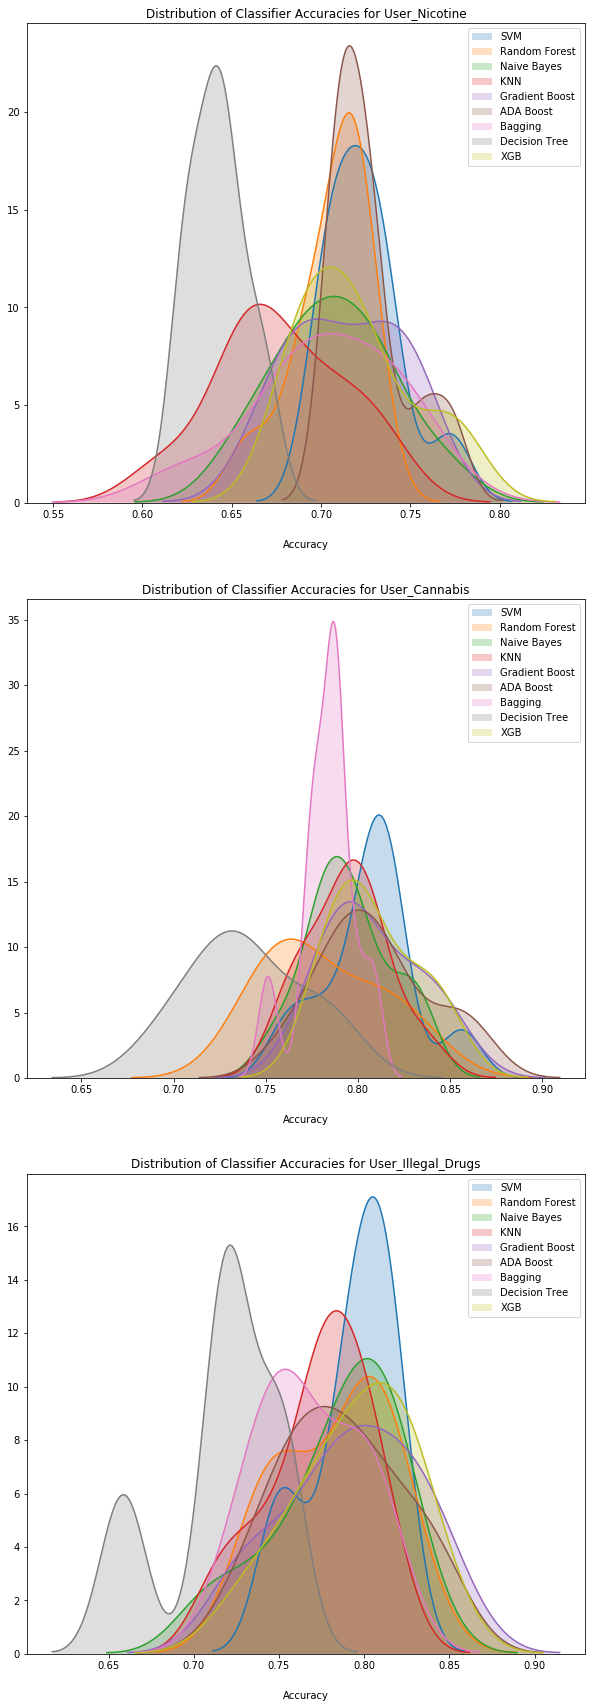

In [140]:
#For loop to visualize classifiers for each target
fig = plt.figure(figsize=(10,30))

for i, target in enumerate(target_names):
    y = finalized_df[target]
    means = []
    
    mean_accuracies = []
    model_names_list = []
    
    #Calculating cross validation scores for each model in a loop
    for j, model in enumerate(list_of_models):
        accuracy = cross_val_score(model, scaled_X, y, cv=kfold, scoring="accuracy", n_jobs=-1)
        means.append(accuracy)
        
        mean_accuracies.append(np.mean(accuracy))
        model_names_list.append(list_of_model_names[j])
        
        
        #print(list_of_model_names[j], np.mean(accuracy))
        

    ax = fig.add_subplot(3,1,i+1)

    #Putting those scores into a visualization
    for i in range(len(means)):
        sns.distplot(means[i], hist=False, kde_kws={'shade': True})

    ax.set_title(f'Distribution of Classifier Accuracies for {target}')
    ax.legend(list_of_model_names)
    ax.set_xlabel('Accuracy', labelpad=20)
    
    
    d = {'Model Name': model_names_list, 'Mean 10-Fold CV Accuracy': mean_accuracies}
    mean_cv_accuracy_df = pd.DataFrame(data=d)
    
    print(str(target))
    print("")
    print(mean_cv_accuracy_df.sort_values(by=['Mean 10-Fold CV Accuracy'], ascending=False))
    print("")

plt.show()

Based on the above accuracy visualizations and accuracy scores for each classifier, it seems like the best classifiers are the ones listed below...

- SVM 
- Random Forest 
- Gradient Boost
- XGB 
- ADA

These are the models that I will perform hyperparameter tuning and model stacking for. 

# Hyper-Parameter Tuning



In [168]:
list_of_models

[SVC(C=2, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
   kernel='rbf', max_iter=-1, probability=False, random_state=11,
   shrinking=True, tol=0.001, verbose=False),
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
             oob_score=False, random_state=11, verbose=0, warm_start=False),
 GaussianNB(priors=None, var_smoothing=1e-09),
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=None, n_neighbors=5, p=2,
            weights='uniform'),
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='deviance', max_depth=3,

In [231]:
#Putting just the best performing models from cross validation into a list
selected_model_names = ['SVC', 'Random Forest', 'Gradient Boosting', 'ADA Boost', 'XGB']
selected_models = [list_of_models[0], list_of_models[1], list_of_models[4], list_of_models[5], list_of_models[8]]

In [232]:
selected_models

[SVC(C=2, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
   kernel='rbf', max_iter=-1, probability=False, random_state=11,
   shrinking=True, tol=0.001, verbose=False),
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
             oob_score=False, random_state=11, verbose=0, warm_start=False),
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='deviance', max_depth=3,
               max_features=None, max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf

# Tuning Models For Each Classifier


In the above models we can see that there are different optimal models for each of the three label targets: nicotine-users, cannabis-users, and illegal-drug users.

As such, I've decided that I will tune models for each of the targets separately. 

After I have tuned each of the models- I will take the best two models for each target and put it into a pipeline with PCA.

# Establishing hyperparameter grids for all three targets

In [234]:
#SVM Tuning
svm_param_grid ={
    'C': [0.5, 1, 2, 5, 10],
    'gamma': [0.01, 0.1, 0.4, 0.8],
    'kernel': ['rbf', 'linear']
}


#Random Forest Tuning
rf_param_grid = {
    'n_estimators': [5, 11, 20],
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 4, 6, 10],
    'min_samples_split': [10, 15, 20],
    'min_samples_leaf': [1, 2, 5]
}

gb_param_grid = {
    'learning_rate': [0.05, 0.1, 0.3],
    'n_estimators': [5, 9, 11],
    'max_depth': [2, 4, 6]
    
}

ada_param_grid = {
    'learning_rate': [0.1, 0.5, 1.0],
    'n_estimators': [5, 11, 25]
}

xgb_param_grid = {
    'learning_rate': [0.05, 0.1, 0.3, 0.9],
    'gamma': [0.1, 1, 5, 10],
    'max_depth': [2, 3, 6]
    
}

# <font color='green'> **Nicotine User Model Tuning**

In [323]:
#Setting y equal to user_nicotine
y = finalized_df['User_Nicotine']

#Grid search to find best parameters for 
svm_grid_search = GridSearchCV(binary_svm, svm_param_grid, cv=kfold)
svm_grid_search.fit(scaled_X, y)

#Gridsearch to find best parameters for random forest model
rf_grid_search = GridSearchCV(binary_forest, rf_param_grid, cv=kfold)
rf_grid_search.fit(scaled_X, y)

gb_grid_search = GridSearchCV(binary_gradient, gb_param_grid, cv=kfold)
gb_grid_search.fit(scaled_X, y)

ada_grid_search = GridSearchCV(binary_adaboost, ada_param_grid, cv=kfold)
ada_grid_search.fit(scaled_X, y)

xgb_grid_search = GridSearchCV(binary_XGB, xgb_param_grid, cv=kfold)
xgb_grid_search.fit(scaled_X, y)

GridSearchCV(cv=KFold(n_splits=10, random_state=11, shuffle=True),
       error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=11, silent=True,
       subsample=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'learning_rate': [0.05, 0.1, 0.3, 0.9], 'gamma': [0.1, 1, 5, 10], 'max_depth': [2, 3, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [325]:
#Putting all of the grid searched models into a list so I can iterate through them and put the results into a dataframe
list_of_fitted_grid_searches = [svm_grid_search, rf_grid_search, gb_grid_search, ada_grid_search, xgb_grid_search]

In [326]:
# Compiling a list of all the new model accuracies and their optimal parameters into a dataframe
grid_search_results_list = []

for i, gs in enumerate(list_of_fitted_grid_searches):
    
    testing_accuracy = str("{:.4}%".format(gs.best_score_ * 100))
    optimal_parameters = gs.best_params_

    grid_search_results_list.append([selected_model_names[i], testing_accuracy, optimal_parameters])

In [327]:
grid_search_results_df = pd.DataFrame(data=grid_search_results_list, columns=['Model', 'Testing Accuracy', 'Optimal Parameters'])
grid_search_results_df

,Model,Testing Accuracy,Optimal Parameters
0,SVC,73.21%,"{'C': 0.5, 'gamma': 0.1, 'kernel': 'rbf'}"
1,Random Forest,73.42%,"{'criterion': 'entropy', 'max_depth': 10, 'min..."
2,Gradient Boosting,72.47%,"{'learning_rate': 0.3, 'max_depth': 2, 'n_esti..."
3,ADA Boost,72.47%,"{'learning_rate': 1.0, 'n_estimators': 25}"
4,XGB,73.26%,"{'gamma': 5, 'learning_rate': 0.1, 'max_depth'..."


In [250]:
#Printing out optimal parameters for each model
for i in range(0, len(grid_search_results_df['Model'])):
    print("Optimal Parameters for {}: ".format(grid_search_results_df['Model'][i]))
    print(grid_search_results_df['Optimal Parameters'][i])

Optimal Parameters for SVC: 
{'C': 0.5, 'gamma': 0.1, 'kernel': 'rbf'}
Optimal Parameters for Random Forest: 
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 20}
Optimal Parameters for Gradient Boosting: 
{'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 11}
Optimal Parameters for ADA Boost: 
{'learning_rate': 1.0, 'n_estimators': 25}
Optimal Parameters for XGB: 
{'gamma': 5, 'learning_rate': 0.1, 'max_depth': 6}


In [332]:
# Then, putting those optimal parameters into new final models to be trained and tested
nico_svc_final = SVC(random_state = 11, C=0.5, gamma=0.01, kernel='rbf')
nico_rf_final = RandomForestClassifier(random_state = 11, criterion='entropy', max_depth = 10, min_samples_leaf = 5, min_samples_split = 10, n_estimators = 20)
nico_gb_final = GradientBoostingClassifier(random_state = 11, learning_rate = 0.3, max_depth = 2, n_estimators = 11)
nico_ada_final = AdaBoostClassifier(random_state = 11, learning_rate = 1, n_estimators = 25)
nico_xgb_final = xgb.XGBClassifier(seed=11, gamma = 5, learning_rate = 0.1, max_depth = 6)

list_of_final_models = [nico_svc_final, nico_rf_final, nico_gb_final, nico_ada_final, nico_xgb_final]

In [333]:
# Initializing a train-test-split for final model evaluations
X_train_nic, X_test_nic, y_train_nic, y_test_nic = train_test_split(scaled_X, y, test_size=0.20, random_state= 11)  


In [382]:
# Fitting each model to the training data and then test it using the created function
model_results_dataframe(list_of_final_models, selected_model_names, X_train_nic, y_train_nic, X_test_nic, y_test_nic)

,Model Name,Training Accuracy,Testing Accuracy
4,XGB,0.803050,0.737401
1,Random Forest,0.872679,0.726790
3,ADA Boost,0.756631,0.716180
0,SVC,0.740716,0.710875
2,Gradient Boosting,0.758621,0.708223


<font color='green'> **XGB and Random Forest appear to be the best models for classifying whether or not somone is a nicotine user. Below, I display the confusion matrix and the classification report for the final random forest nicotine model.**



Accuracy Score: 0.7374005305039788


Confusion Matrix:


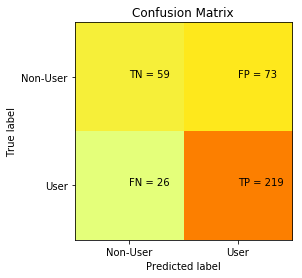



Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.45      0.54       132
           1       0.75      0.89      0.82       245

   micro avg       0.74      0.74      0.74       377
   macro avg       0.72      0.67      0.68       377
weighted avg       0.73      0.74      0.72       377



In [372]:
results_summary(nico_xgb_final, X_train_nic, y_train_nic, X_test_nic, y_test_nic)

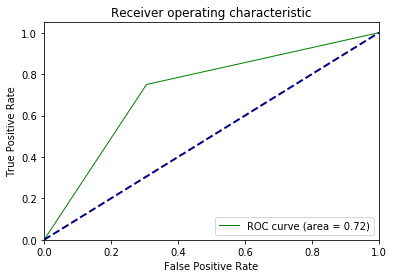

In [375]:
roc_curves(nico_xgb_final, X_train_nic, y_train_nic, X_test_nic, y_test_nic)

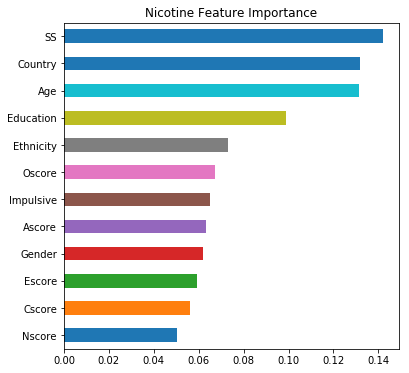

In [489]:
feature_importance_visualization(nico_xgb_final, X_train_nic, y_train_nic, 'Nicotine Feature Importance')

# <font color='green'> **Cannabis User Model Tuning**

<font color = 'red'> **NOTE:** The reason I have repetitive code here is because doing a grid search for five different classifiers is computationally expensive and takes a lot of time. Instead of writing a loop or function that would add to computation time, I tuned each model separately.

In [277]:
#Setting y equal to user_nicotine
y = finalized_df['User_Cannabis']

#Grid search to find best parameters for 
svm_grid_search = GridSearchCV(binary_svm, svm_param_grid, cv=kfold)
svm_grid_search.fit(scaled_X, y)

#Gridsearch to find best parameters for random forest model
rf_grid_search = GridSearchCV(binary_forest, rf_param_grid, cv=kfold)
rf_grid_search.fit(scaled_X, y)

gb_grid_search = GridSearchCV(binary_gradient, gb_param_grid, cv=kfold)
gb_grid_search.fit(scaled_X, y)

ada_grid_search = GridSearchCV(binary_adaboost, ada_param_grid, cv=kfold)
ada_grid_search.fit(scaled_X, y)

xgb_grid_search = GridSearchCV(binary_XGB, xgb_param_grid, cv=kfold)
xgb_grid_search.fit(scaled_X, y)

GridSearchCV(cv=KFold(n_splits=10, random_state=11, shuffle=True),
       error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=11, silent=True,
       subsample=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'learning_rate': [0.05, 0.1, 0.3, 0.9], 'gamma': [0.1, 1, 5, 10], 'max_depth': [2, 3, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [260]:
#Putting all of the grid searched models into a list so I can iterate through them and put the results into a dataframe
list_of_fitted_grid_searches = [svm_grid_search, rf_grid_search, gb_grid_search, ada_grid_search, xgb_grid_search]

In [261]:
# Compiling a list of all the new model accuracies and their optimal parameters into a dataframe
grid_search_results_list = []

for i, gs in enumerate(list_of_fitted_grid_searches):
    
    testing_accuracy = str("{:.4}%".format(gs.best_score_ * 100))
    optimal_parameters = gs.best_params_

    grid_search_results_list.append([selected_model_names[i], testing_accuracy, optimal_parameters])

In [262]:
grid_search_results_df = pd.DataFrame(data=grid_search_results_list, columns=['Model', 'Testing Accuracy', 'Optimal Parameters'])
grid_search_results_df

,Model,Testing Accuracy,Optimal Parameters
0,SVC,81.8%,"{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}"
1,Random Forest,81.33%,"{'criterion': 'entropy', 'max_depth': 10, 'min..."
2,Gradient Boosting,81.33%,"{'learning_rate': 0.3, 'max_depth': 2, 'n_esti..."
3,ADA Boost,80.9%,"{'learning_rate': 0.5, 'n_estimators': 25}"
4,XGB,82.02%,"{'gamma': 10, 'learning_rate': 0.3, 'max_depth..."


In [264]:
#Printing out optimal parameters for each model
for i in range(0, len(grid_search_results_df['Model'])):
    print("Optimal Parameters for {}: ".format(grid_search_results_df['Model'][i]))
    print(grid_search_results_df['Optimal Parameters'][i])

Optimal Parameters for SVC: 
{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Optimal Parameters for Random Forest: 
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 11}
Optimal Parameters for Gradient Boosting: 
{'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 11}
Optimal Parameters for ADA Boost: 
{'learning_rate': 0.5, 'n_estimators': 25}
Optimal Parameters for XGB: 
{'gamma': 10, 'learning_rate': 0.3, 'max_depth': 2}


In [303]:
# Then, putting those optimal parameters into new final models to be trained and tested
cannabis_svc_final = SVC(random_state = 11, C=10, gamma=0.01, kernel='rbf')
cannabis_rf_final = RandomForestClassifier(random_state = 11, criterion='entropy', max_depth = 10, min_samples_leaf = 1, min_samples_split = 20, n_estimators = 11)
cannabis_gb_final = GradientBoostingClassifier(random_state = 11, learning_rate = 0.3, max_depth = 2, n_estimators = 11)
cannabis_ada_final = AdaBoostClassifier(random_state = 11, learning_rate = 0.5, n_estimators = 25)
cannabis_xgb_final = xgb.XGBClassifier(seed=11, gamma = 10, learning_rate = 0.3, max_depth = 2)

list_of_final_models = [cannabis_svc_final, cannabis_rf_final, cannabis_gb_final, cannabis_ada_final, cannabis_xgb_final]

In [304]:
# Initializing a train-test-split for final model evaluations
X_train_cannabis, X_test_cannabis, y_train_cannabis, y_test_cannabis = train_test_split(scaled_X, y, test_size=0.20, random_state= 11)  


In [305]:
# Fitting each model to the training data and then test it using the created function
model_results_dataframe(list_of_final_models, selected_model_names, X_train_cannabis, y_train_cannabis, X_test_cannabis, y_test_cannabis)

,Model Name,Training Accuracy,Testing Accuracy
0,SVC,0.833554,0.811671
4,XGB,0.826923,0.787798
1,Random Forest,0.893236,0.785146
2,Gradient Boosting,0.830239,0.777188
3,ADA Boost,0.823607,0.777188


<font color='green'> **XGB and SVC appear to be the best models for classification of whether or not someone is a cannabis user. Below, I display the confusion matrix and the classification report for the final SVC nicotine model.**



Accuracy Score: 0.8116710875331565


Confusion Matrix:


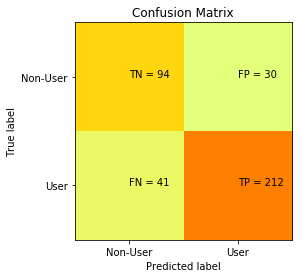



Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.76      0.73       124
           1       0.88      0.84      0.86       253

   micro avg       0.81      0.81      0.81       377
   macro avg       0.79      0.80      0.79       377
weighted avg       0.82      0.81      0.81       377



In [377]:
results_summary(cannabis_svc_final, X_train_cannabis, y_train_cannabis, X_test_cannabis, y_test_cannabis)



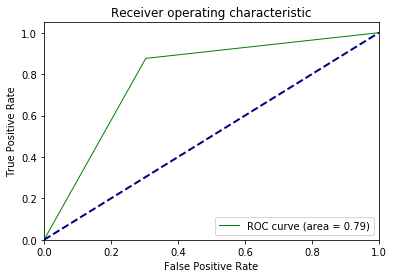

In [378]:
roc_curves(cannabis_svc_final, X_train_cannabis, y_train_cannabis, X_test_cannabis, y_test_cannabis)

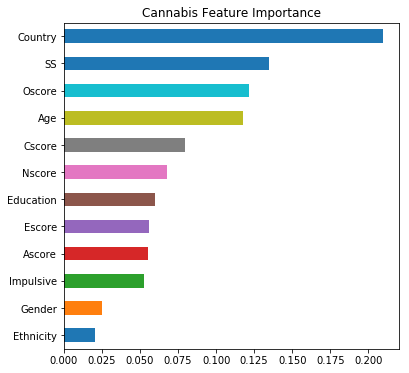

In [488]:
feature_importance_visualization(cannabis_rf_final, X_train_cannabis, y_train_cannabis, "Cannabis Feature Importance")

# <font color='green'> **Illegal Drugs User Model Tuning**

<font color = 'red'> **NOTE:** The reason I have repetitive code here is because doing a grid search for five different classifiers is computationally expensive and takes a lot of time. Instead of writing a loop or function that would add to computation time, I tuned each model separately.

In [269]:
#Setting y equal to user_nicotine
y = finalized_df['User_Illegal_Drugs']

#Grid search to find best parameters for 
svm_grid_search = GridSearchCV(binary_svm, svm_param_grid, cv=kfold)
svm_grid_search.fit(scaled_X, y)

#Gridsearch to find best parameters for random forest model
rf_grid_search = GridSearchCV(binary_forest, rf_param_grid, cv=kfold)
rf_grid_search.fit(scaled_X, y)

gb_grid_search = GridSearchCV(binary_gradient, gb_param_grid, cv=kfold)
gb_grid_search.fit(scaled_X, y)

ada_grid_search = GridSearchCV(binary_adaboost, ada_param_grid, cv=kfold)
ada_grid_search.fit(scaled_X, y)

xgb_grid_search = GridSearchCV(binary_XGB, xgb_param_grid, cv=kfold)
xgb_grid_search.fit(scaled_X, y)

GridSearchCV(cv=KFold(n_splits=10, random_state=11, shuffle=True),
       error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=11, silent=True,
       subsample=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'learning_rate': [0.05, 0.1, 0.3, 0.9], 'gamma': [0.1, 1, 5, 10], 'max_depth': [2, 3, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [270]:
#Putting all of the grid searched models into a list so I can iterate through them and put the results into a dataframe
list_of_fitted_grid_searches = [svm_grid_search, rf_grid_search, gb_grid_search, ada_grid_search, xgb_grid_search]

In [271]:
# Compiling a list of all the new model accuracies and their optimal parameters into a dataframe
grid_search_results_list = []

for i, gs in enumerate(list_of_fitted_grid_searches):
    
    testing_accuracy = str("{:.4}%".format(gs.best_score_ * 100))
    optimal_parameters = gs.best_params_

    grid_search_results_list.append([selected_model_names[i], testing_accuracy, optimal_parameters])

In [272]:
grid_search_results_df = pd.DataFrame(data=grid_search_results_list, columns=['Model', 'Testing Accuracy', 'Optimal Parameters'])
grid_search_results_df

,Model,Testing Accuracy,Optimal Parameters
0,SVC,80.27%,"{'C': 5, 'gamma': 0.01, 'kernel': 'rbf'}"
1,Random Forest,80.27%,"{'criterion': 'gini', 'max_depth': 10, 'min_sa..."
2,Gradient Boosting,78.89%,"{'learning_rate': 0.3, 'max_depth': 4, 'n_esti..."
3,ADA Boost,78.83%,"{'learning_rate': 1.0, 'n_estimators': 25}"
4,XGB,79.95%,"{'gamma': 0.1, 'learning_rate': 0.3, 'max_dept..."


In [273]:
#Printing out optimal parameters for each model
for i in range(0, len(grid_search_results_df['Model'])):
    print("Optimal Parameters for {}: ".format(grid_search_results_df['Model'][i]))
    print(grid_search_results_df['Optimal Parameters'][i])

Optimal Parameters for SVC: 
{'C': 5, 'gamma': 0.01, 'kernel': 'rbf'}
Optimal Parameters for Random Forest: 
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 15, 'n_estimators': 20}
Optimal Parameters for Gradient Boosting: 
{'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 11}
Optimal Parameters for ADA Boost: 
{'learning_rate': 1.0, 'n_estimators': 25}
Optimal Parameters for XGB: 
{'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 2}


In [315]:
# Then, putting those optimal parameters into new final models to be trained and tested
illegal_svc_final = SVC(random_state = 11, C=5, gamma=0.01, kernel='rbf')
illegal_rf_final = RandomForestClassifier(random_state = 11, criterion='gini', max_depth = 10, min_samples_leaf = 5, min_samples_split = 15, n_estimators = 20)
illegal_gb_final = GradientBoostingClassifier(random_state = 11, learning_rate = 0.3, max_depth = 4, n_estimators = 11)
illegal_ada_final = AdaBoostClassifier(random_state = 11, learning_rate = 1, n_estimators = 25)
illegal_xgb_final = xgb.XGBClassifier(seed=11, gamma = 0.1, learning_rate = 0.3, max_depth = 2)

list_of_final_models = [illegal_svc_final, illegal_rf_final, illegal_gb_final, illegal_ada_final, illegal_xgb_final]

In [316]:
# Initializing a train-test-split for final model evaluations
X_train_illegal, X_test_illegal, y_train_illegal, y_test_illegal = train_test_split(scaled_X, y, test_size=0.20, random_state= 11)  


In [317]:
# Fitting each model to the training data and then test it using the created function    
model_results_dataframe(list_of_final_models, selected_model_names, X_train_illegal, y_train_illegal, X_test_illegal, y_test_illegal)

,Model Name,Training Accuracy,Testing Accuracy
0,SVC,0.831565,0.809019
1,Random Forest,0.890584,0.793103
2,Gradient Boosting,0.876658,0.787798
4,XGB,0.876658,0.782493
3,ADA Boost,0.818966,0.777188


<font color='green'> **Here, random forest and svc appear to be the best models for classification of whether or not someone is a cannabis user. Below, I display the confusion matrix and the classification report for the final random forest illegal drugs model.**



Accuracy Score: 0.7931034482758621


Confusion Matrix:


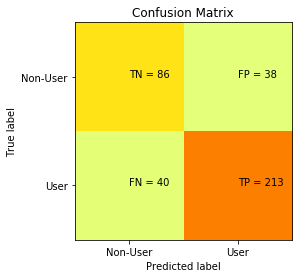



Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.69      0.69       124
           1       0.85      0.84      0.85       253

   micro avg       0.79      0.79      0.79       377
   macro avg       0.77      0.77      0.77       377
weighted avg       0.79      0.79      0.79       377



In [379]:
results_summary(illegal_svc_final, X_train_illegal, y_train_illegal, X_test_illegal, y_test_illegal)

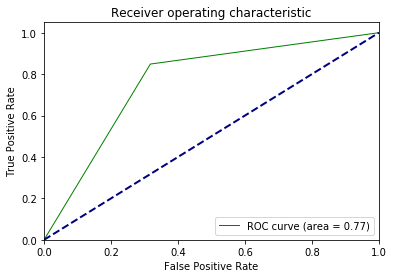

In [380]:
roc_curves(illegal_svc_final, X_train_illegal, y_train_illegal, X_test_illegal, y_test_illegal)

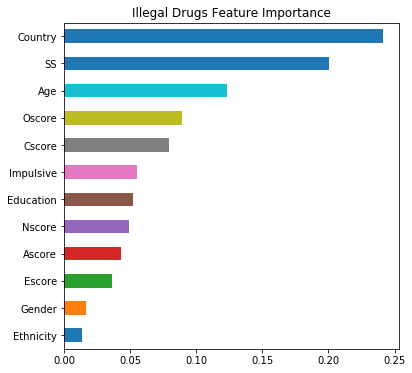

In [487]:
feature_importance_visualization(illegal_rf_final, X_train_illegal, y_train_illegal, 'Illegal Drugs Feature Importance')

# <font color='green'> Modeling Conclusions

After testing simple models, scaling and hyperparameter tuning, and evaluating the final models, I've arrived at what I believe to be an optimized model for each of the classifiers.

**Nicotine Users**
- For classifying whether or not someone is a nicotine user, the random forest model yielded the highest accuracy results at 73.7%.
- The most important features in the model were SS, Country, Age and Education

**Cannabis Users**
- For classifying whether or not someone is a cannabis user, the SVC model yielded the highest accuracy results at 81.1%
- The most important features in the model were SS, Country, Age and Gender

**Illegal Drug Users**
- For classifying whether or not someone is an illegal drugs user, the SVC model yielded the highest accuracy results at 80.9%
- The most important features in the model were Country, SS, Age, and Oscore

It is interesting that Nicotine use seems to be the most difficult to predict using personality features. 

# <font color='blue'> Hypothesis Testing for Significant Differences between Users and Non-Users

For each classifier (nicotine user, cannabis user, illegal drug user) I will test to see if there is a significant difference between each of the groups for each of the 7 personality trait features. To test these, I will use a welch's t-test to determine if the difference between the means of the two groups is significant. 

## <font color='green'> Nicotine User Hypothesis Tests
    
H$_0$: $\mu_{Nicotine User Scores}$ = $\mu_{Nicotine Non-User Scores}$ <br>
H$_a$: $\mu_{Nicotine User Scores}$ ≠ $\mu_{Nicotine Non-User Scores}$

In [482]:
#Creating a dataframe to store the results of the tests
nicotine_comparison_df = pd.DataFrame(columns = ['Feature Name', 'User Mean', 'Non-User Mean', 
                                        'Effect Size', 'p-val', 'Effect Size Cohen',
                                        'Result Sentence'])

#Using a standard scalar to scale all of the data before t-testing
finalized_df.iloc[:,:12] = scale.fit_transform(finalized_df.iloc[:,:12])

#This loop iterates through a list of all 7 personality trait columns and performs a t-test between users and non-users
#for each trait
for col in list(finalized_df.columns[5:-3]):
    non_user_data = finalized_df[finalized_df['User_Nicotine']==0][col]
    user_data = finalized_df[finalized_df['User_Nicotine']==1][col]
    
    non_user_mean = non_user_data.mean()
    user_mean = user_data.mean()
    
    #Using helper function to get p_val and effect sizes
    p_val, effect_size_quantity, effect_size_cohen = ttest_helper(non_user_data, user_data)
    
    p_val = round(p_val, 4)
    
    
    # Creating summary sentences to put into the dataframe
    if (user_mean > non_user_mean) & (p_val < 0.05):
        result_sentence = str('Users have higher {} scores than Non-users'.format(col))
        
    elif(non_user_mean > user_mean) & (p_val < 0.05):
        result_sentence = str('Users have lower {} scores than Non-users'.format(col))
        
    else:
        result_sentence = str('No statistically significant difference')
    
    #Updating the dataframe with the results
    nicotine_comparison_df = nicotine_comparison_df.append({'Feature Name': col, 'User Mean': user_mean, 'Non-User Mean': non_user_mean,
                                         'Effect Size': effect_size_quantity, 'p-val': p_val, 
                                         'Effect Size Cohen': effect_size_cohen, 
                                         'Result Sentence': result_sentence}, ignore_index=True)

In [483]:
nicotine_comparison_df

,Feature Name,User Mean,Non-User Mean,Effect Size,p-val,Effect Size Cohen,Result Sentence
0,Nscore,0.089175,-0.181509,-0.27,0.0000,-0.273,Users have higher Nscore scores than Non-users
1,Escore,-0.006869,0.013982,0.02,0.6631,0.021,No statistically significant difference
2,Oscore,0.146168,-0.297514,-0.44,0.0000,-0.453,Users have higher Oscore scores than Non-users
3,Ascore,-0.081971,0.166845,0.25,0.0000,0.250,Users have lower Ascore scores than Non-users
4,Cscore,-0.140381,0.285735,0.43,0.0000,0.435,Users have lower Cscore scores than Non-users
5,Impulsive,0.150218,-0.305758,-0.46,0.0000,-0.467,Users have higher Impulsive scores than Non-users
6,SS,0.211002,-0.429480,-0.64,0.0000,-0.671,Users have higher SS scores than Non-users


## <font color='green'> Nicotine Hypothesis Test Findings

Nicotine users have higher...
- Neuroticism
- Openness to experience
- Impulsiveness
- Sensation Seeking

Nicotine non-users have higher...
- Agreeableness
- Conscientiousness

Users and non-users show no statistical difference for....
- Extraversion

The biggest differences in terms of effect size between the two groups are sensation seeking and impulsiveness.

## <font color='green'> Cannabis User Hypothesis Tests
    
H$_0$: $\mu_{Cannabis User Scores}$ = $\mu_{Cannabis Non-User Scores}$ <br>
H$_a$: $\mu_{Cannabis User Scores}$ ≠ $\mu_{Cannabis Non-User Scores}$

In [478]:
#Creating a dataframe to store the results of the tests
cannabis_comparison_df = pd.DataFrame(columns = ['Feature Name', 'User Mean', 'Non-User Mean', 
                                        'Effect Size', 'p-val', 'Effect Size Cohen',
                                        'Result Sentence'])

#Using a standard scalar to scale all of the data before t-testing
finalized_df.iloc[:,:12] = scale.fit_transform(finalized_df.iloc[:,:12])

#This loop iterates through a list of all 7 personality trait columns and performs a t-test between users and non-users
#for each trait
for col in list(finalized_df.columns[5:-3]):
    non_user_data = finalized_df[finalized_df['User_Cannabis']==0][col]
    user_data = finalized_df[finalized_df['User_Cannabis']==1][col]
    
    non_user_mean = non_user_data.mean()
    user_mean = user_data.mean()
    
    #Using helper function to get p_val and effect sizes
    p_val, effect_size_quantity, effect_size_cohen = ttest_helper(non_user_data, user_data)
    
    p_val = round(p_val, 4)
    
    
    # Creating summary sentences to put into the dataframe
    if (user_mean > non_user_mean) & (p_val < 0.05):
        result_sentence = str('Users have higher {} scores than Non-users'.format(col))
        
    elif(non_user_mean > user_mean) & (p_val < 0.05):
        result_sentence = str('Users have lower {} scores than Non-users'.format(col))
        
    else:
        result_sentence = str('No statistically significant difference')
    
    #Updating the dataframe with the results
    cannabis_comparison_df = cannabis_comparison_df.append({'Feature Name': col, 'User Mean': user_mean, 'Non-User Mean': non_user_mean,
                                         'Effect Size': effect_size_quantity, 'p-val': p_val, 
                                         'Effect Size Cohen': effect_size_cohen, 
                                         'Result Sentence': result_sentence}, ignore_index=True)

In [479]:
cannabis_comparison_df

,Feature Name,User Mean,Non-User Mean,Effect Size,p-val,Effect Size Cohen,Result Sentence
0,Nscore,0.097767,-0.199476,-0.30,0.0000,-0.300,Users have higher Nscore scores than non-users
1,Escore,-0.027166,0.055428,0.08,0.0776,0.083,No statistically significant difference
2,Oscore,0.245181,-0.500249,-0.75,0.0000,-0.795,Users have higher Oscore scores than non-users
3,Ascore,-0.117396,0.239525,0.36,0.0000,0.362,Users have lower Ascore scores than non-users
4,Cscore,-0.190383,0.388442,0.58,0.0000,0.601,Users have lower Cscore scores than non-users
5,Impulsive,0.206695,-0.421725,-0.63,0.0000,-0.657,Users have higher Impulsive scores than non-users
6,SS,0.286898,-0.585364,-0.87,0.0000,-0.956,Users have higher SS scores than non-users


## <font color='green'> Cannabis Hypothesis Test Findings

Cannabis users have higher...
- Neuroticism
- Openness to experience
- Impulsiveness
- Sensation Seeking

Cannabis non-users have higher...
- Agreeableness
- Conscientiousness

Users and non-users show no statistical difference for....
- Extraversion

The biggest differences in terms of effect size between the two groups are sensation seeking and openness to experience

## <font color='green'> IllegalDrugs User Hypothesis Tests
    
H$_0$: $\mu_{IllegalDrugs User Scores}$ = $\mu_{IllegalDrugs Non-User Scores}$ <br>
H$_a$: $\mu_{IllegalDrugs User Scores}$ ≠ $\mu_{IllegalDrugs Non-User Scores}$

In [484]:
#Creating a dataframe to store the results of the tests
illegals_comparison_df = pd.DataFrame(columns = ['Feature Name', 'User Mean', 'Non-User Mean', 
                                        'Effect Size', 'p-val', 'Effect Size Cohen',
                                        'Result Sentence'])

#Using a standard scalar to scale all of the data before t-testing
finalized_df.iloc[:,:12] = scale.fit_transform(finalized_df.iloc[:,:12])

#This loop iterates through a list of all 7 personality trait columns and performs a t-test between users and non-users
#for each trait
for col in list(finalized_df.columns[5:-3]):
    non_user_data = finalized_df[finalized_df['User_Illegal_Drugs']==0][col]
    user_data = finalized_df[finalized_df['User_Illegal_Drugs']==1][col]
    
    non_user_mean = non_user_data.mean()
    user_mean = user_data.mean()
    
    #Using helper function to get p_val and effect sizes
    p_val, effect_size_quantity, effect_size_cohen = ttest_helper(non_user_data, user_data)
    
    p_val = round(p_val, 4)
    
    
    # Creating summary sentences to put into the dataframe
    if (user_mean > non_user_mean) & (p_val < 0.05):
        result_sentence = str('Users have higher {} scores than Non-users'.format(col))
        
    elif(non_user_mean > user_mean) & (p_val < 0.05):
        result_sentence = str('Users have lower {} scores than Non-users'.format(col))
        
    else:
        result_sentence = str('No statistically significant difference')
    
    #Updating the dataframe with the results
    illegals_comparison_df = illegals_comparison_df.append({'Feature Name': col, 'User Mean': user_mean, 'Non-User Mean': non_user_mean,
                                         'Effect Size': effect_size_quantity, 'p-val': p_val, 
                                         'Effect Size Cohen': effect_size_cohen, 
                                         'Result Sentence': result_sentence}, ignore_index=True)

In [485]:
illegals_comparison_df

,Feature Name,User Mean,Non-User Mean,Effect Size,p-val,Effect Size Cohen,Result Sentence
0,Nscore,0.131798,-0.257605,-0.39,0.0000,-0.396,Users have higher Nscore scores than Non-users
1,Escore,-0.046889,0.091647,0.14,0.0027,0.139,Users have lower Escore scores than Non-users
2,Oscore,0.225973,-0.441675,-0.67,0.0000,-0.703,Users have higher Oscore scores than Non-users
3,Ascore,-0.127554,0.249310,0.38,0.0000,0.383,Users have lower Ascore scores than Non-users
4,Cscore,-0.217380,0.424880,0.64,0.0000,0.674,Users have lower Cscore scores than Non-users
5,Impulsive,0.209115,-0.408725,-0.62,0.0000,-0.646,Users have higher Impulsive scores than Non-users
6,SS,0.277456,-0.542301,-0.82,0.0000,-0.889,Users have higher SS scores than Non-users


## <font color='green'> Illegal Drug Hypothesis Test Findings

Illegal Drug users have higher...
- Neuroticism
- Openness to experience
- Impulsiveness
- Sensation Seeking
- Extraversion

Illegal Drug non-users have higher...
- Agreeableness
- Conscientiousness


The biggest differences in terms of effect size between the two groups are sensation seeking and openness to experience

# Project Conclusion

At the conclusion of the project, I have created a predictive model which can be used as a risk assessment tool to determine which individuals are most at risk of trying illegal (or legal) drugs. 

It was notably more difficult to predict Nicotine use, suggesting that there are predictive factors outside the scope of the dataset features which may affect Nicotinue usage. Cannabis and illegal drugs were far easier to predict based on demographics and personality traits, and ultimately I was able to predict both with over 80% accuracy.

After assessing feature importance for each of the models, each classifier has a slightly different feature importance order, but there were several consistent top-performers. 

Among the demographics factors, country, age, and education were the most important features.

Among personality factors, Oscore (Openness) and Cscore(Conscientiousness) were the most important factors for all three classifiers. 

# Future Work

- Analyze addictive behavior by classifying whether or not someone has used multiple drugs in the past week
- Use this information to create a "is_drug_abuser" column that indicates whether or not someone is abusing drugs
- Gather more detailed demographic information for each survey respondent. This would hopefully inmprove the accuracy of the nicotine classifier
- Somehow find a sample that is more representative of the population. This sample is clearly biased towards users of drugs, as it is highly unlikely that more than 50% of the population uses illegal drugs. Find a way to sample a more representative amount of users/non-users.